In [ ]:
!pip install neuralforecast
!pip install feature-engine

In [2]:
import os
import sys
import math
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNBEATSx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from neuralforecast.losses.numpy import mase as mase_numpy
from utilsforecast.losses import mase
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
import sklearn
import neuralforecast
import feature_engine

In [3]:
# Versões
print('Versões:')
print('Python: %s' % sys.version)
print('Pandas: %s' % pd.__version__)
print('Numpy: %s' % np.__version__)
print('Sklearn: %s' % sklearn.__version__)
print('NeuralForecast: %s' % neuralforecast.__version__)
print('Feature-Engine: %s' % feature_engine.__version__)

Versões:
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Sklearn: 1.6.1
NeuralForecast: 3.0.1
Feature-Engine: 1.8.3


In [4]:
ROOT = "/content/drive/MyDrive/dl-project"

FEATURES = [
    'pressure_1',
    'pressure_2',
    'pressure_3',
    'pressure_4',
    'pressure_5',
    'pressure_6',
    'pressure_7'
]
SEED = 78

horizon = 187
input_size = 187

In [5]:
train = pd.read_csv(f"{ROOT}/data/train_data_scaled.csv")
test = pd.read_csv(f"{ROOT}/data/test_data_scaled.csv")

In [6]:
# Requrimento do nixtla
train['unique_id'] = 'slug_flow'
train['ds'] = train['time']
train['y'] = train['liquid_flow_rate']


test['unique_id'] = 'slug_flow'
test['ds'] = test['time']
test['y'] = test['liquid_flow_rate']

In [7]:
nbeatsx_config = AutoNBEATSx.get_default_config(h = horizon, backend="ray")
nbeatsx_config.update(
    {
        'input_size': input_size,
        'exclude_insample_y': True,
        'hist_exog_list': FEATURES,
        'early_stop_patience_steps': 10,
        'val_check_steps': 100,
        'random_seed': SEED
    }
)
nbeatsx_config

{'h': None,
 'learning_rate': <ray.tune.search.sample.Float at 0x7dcc78fda5d0>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x7dcc78fda750>,
 'max_steps': <ray.tune.search.sample.Categorical at 0x7dcc78fda850>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x7dcc78fda950>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x7dcc78fdaa50>,
 'loss': None,
 'random_seed': 78,
 'input_size': 187,
 'step_size': <ray.tune.search.sample.Categorical at 0x7dcc76f7b1d0>,
 'exclude_insample_y': True,
 'hist_exog_list': ['pressure_1',
  'pressure_2',
  'pressure_3',
  'pressure_4',
  'pressure_5',
  'pressure_6',
  'pressure_7'],
 'early_stop_patience_steps': 10,
 'val_check_steps': 100}

### Training

In [8]:
models = [
    AutoNBEATSx(
        h=horizon,
        loss=MAE(),
        config=nbeatsx_config,
        search_alg=HyperOptSearch(),
        backend='ray',
        num_samples=30
    )
]

In [ ]:
nf = NeuralForecast(
    models=models,
    freq=1
)
nf.fit(
    df=train, val_size=horizon
)

In [10]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train.tail(input_size), test])

In [11]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [12]:
forecasts_list = []
for input_df in inputs_for_predicions_list:
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [13]:
forecasts_output = pd.concat(forecasts_list)
forecasts_output

,unique_id,ds,AutoNBEATSx
0,slug_flow,1501,0.457891
1,slug_flow,1502,0.473480
2,slug_flow,1503,0.485704
3,slug_flow,1504,0.499576
4,slug_flow,1505,0.511875
...,...,...,...
182,slug_flow,3179,0.269361
183,slug_flow,3180,0.273963
184,slug_flow,3181,0.277767
185,slug_flow,3182,0.281273


In [14]:
ground_truth = test[['unique_id', 'ds', 'y']]
ground_truth

,unique_id,ds,y
0,slug_flow,1501,0.459397
1,slug_flow,1502,0.471283
2,slug_flow,1503,0.484231
3,slug_flow,1504,0.496564
4,slug_flow,1505,0.510421
...,...,...,...
1495,slug_flow,2996,0.279759
1496,slug_flow,2997,0.279714
1497,slug_flow,2998,0.279125
1498,slug_flow,2999,0.278436


In [15]:
exogenous_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='left'
)

exogenous_results

,unique_id,ds,y,AutoNBEATSx
0,slug_flow,1501,0.459397,0.457891
1,slug_flow,1502,0.471283,0.473480
2,slug_flow,1503,0.484231,0.485704
3,slug_flow,1504,0.496564,0.499576
4,slug_flow,1505,0.510421,0.511875
...,...,...,...,...
1495,slug_flow,2996,0.279759,0.280611
1496,slug_flow,2997,0.279714,0.279619
1497,slug_flow,2998,0.279125,0.278882
1498,slug_flow,2999,0.278436,0.280959


In [16]:
file_name = "nbeatsx_bayesopt"
version = "v1"
exogenous_results.to_csv(f"{ROOT}/results/{file_name}_{version}.csv", index=False, mode='x')

In [18]:
##########################################
# Espaço de busca da otimizaçao bayseana
##########################################

# from statsforecast.models import AutoNHITS
from ray.tune.search.sample import Categorical, LogUniform

# Get the config dictionary with the Ray Tune sampler objects
config = AutoNBEATSx.get_default_config(h=horizon, backend='ray')

print("Inspecting the AutoNHITS Default Search Space Programmatically:\n")

# Iterate through the hyperparameters and their sampler objects
for param, sampler in config.items():
    print(f"Hyperparameter: '{param}'")

    if isinstance(sampler, Categorical):
        # This object is created by tune.choice([...])
        print(f"  -> Type: Categorical Choice")
        print(f"  -> Values: {sampler.categories}\n")

    elif isinstance(sampler, LogUniform):
        # This object is created by tune.loguniform(...)
        print(f"  -> Type: Log-Uniform Float")
        print(f"  -> Lower Bound: {sampler.lower}")
        print(f"  -> Upper Bound: {sampler.upper}\n")

    else:
        # This handles any fixed values that are not Ray Tune samplers
        print(f"  -> Type: Fixed Value")
        print(f"  -> Value: {sampler}\n")

Inspecting the AutoNHITS Default Search Space Programmatically:

Hyperparameter: 'h'
  -> Type: Fixed Value
  -> Value: None

Hyperparameter: 'learning_rate'
  -> Type: Fixed Value
  -> Value: <ray.tune.search.sample.Float object at 0x7dcc78fda5d0>

Hyperparameter: 'scaler_type'
  -> Type: Categorical Choice
  -> Values: [None, 'robust', 'standard']

Hyperparameter: 'max_steps'
  -> Type: Categorical Choice
  -> Values: [500, 1000]

Hyperparameter: 'batch_size'
  -> Type: Categorical Choice
  -> Values: [32, 64, 128, 256]

Hyperparameter: 'windows_batch_size'
  -> Type: Categorical Choice
  -> Values: [128, 256, 512, 1024]

Hyperparameter: 'loss'
  -> Type: Fixed Value
  -> Value: None

Hyperparameter: 'random_seed'
  -> Type: Fixed Value
  -> Value: <ray.tune.search.sample.Integer object at 0x7dcc78fdab10>

Hyperparameter: 'input_size'
  -> Type: Categorical Choice
  -> Values: [187, 374, 561, 748, 935]

Hyperparameter: 'step_size'
  -> Type: Categorical Choice
  -> Values: [1, 187]



In [19]:
####################################################
# Salvar os parametros de cada etapa da otimizaçao.
####################################################

pd.set_option('display.max_columns', None)
bayesopt_logs = nf.models[0].results.get_dataframe()
bayesopt_logs.to_csv(f"{ROOT}/results/{file_name}_bayesopt_logs-{version}.csv", index=False, mode='x')

# bayesopt_logs

In [20]:
bayesopt_logs = pd.read_csv(f"{ROOT}/results/{file_name}_bayesopt_logs-{version}.csv")

In [21]:
########################################
# Pegar os hiper-parâmetros selecionados
########################################

(
    bayesopt_logs
    .loc[
        bayesopt_logs['loss'] == bayesopt_logs['loss'].min(), [column for column in bayesopt_logs.columns if column.startswith("config/")]
    ]
    .rename(columns={column: column.replace('config/', '') for column in bayesopt_logs.columns})
    .to_dict(orient='records')
)

[{'h': 187,
  'learning_rate': 0.0006852073734272,
  'scaler_type': 'standard',
  'max_steps': 1000,
  'batch_size': 32,
  'windows_batch_size': 1024,
  'loss': 'MAE()',
  'random_seed': 78,
  'input_size': 187,
  'step_size': 1,
  'exclude_insample_y': True,
  'hist_exog_list': "('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7')",
  'early_stop_patience_steps': 10,
  'val_check_steps': 100,
  'valid_loss': 'MAE()'}]

In [ ]:
# Salvar modelo
model_dir = f"{ROOT}/models/{file_name}_BayesOptNHITS_{version}/"
os.makedirs(model_dir, exist_ok=True)
nf.save(path=model_dir)

### Performance

In [22]:
import joblib
import pandas as pd

In [23]:
ROOT = "/content/drive/MyDrive/dl-project"
file_name = "nbeatsx_bayesopt"
version = "v1"
exogenous_results = pd.read_csv(f"{ROOT}/results/{file_name}_{version}.csv")

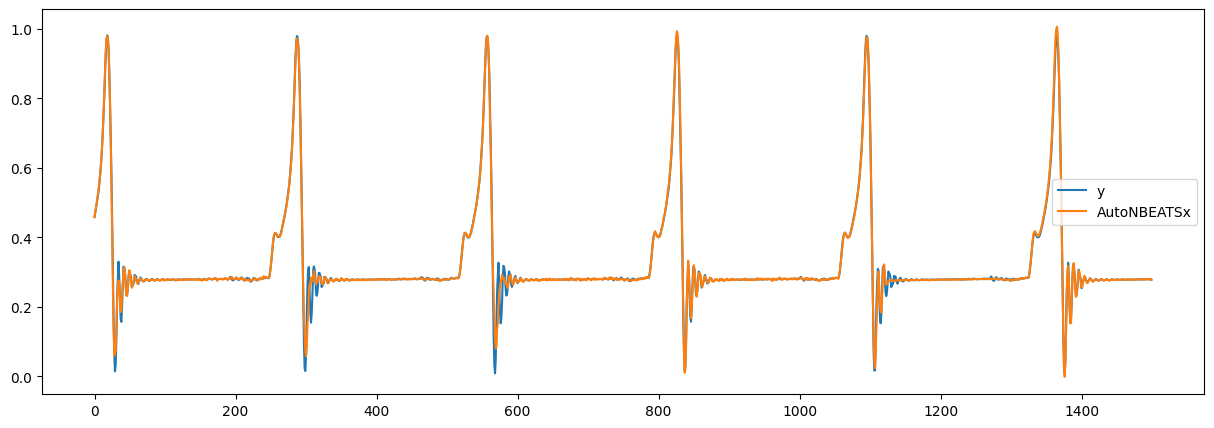

In [25]:
exogenous_results[['y', 'AutoNBEATSx']].plot(figsize=(15, 5));

In [26]:
scaler = joblib.load(f"{ROOT}/data/scaler.joblib")

In [ ]:
############
# Métricas
############

In [28]:
##################################
# Retornar para a escala original
##################################

n_rows = len(exogenous_results)
dummy_df = pd.DataFrame(
    data={
        'pressure_1': [0]*n_rows,
        'pressure_2': [0]*n_rows,
        'pressure_3': [0]*n_rows,
        'pressure_4': [0]*n_rows,
        'pressure_5': [0]*n_rows,
        'pressure_6': [0]*n_rows,
        'pressure_7': [0]*n_rows,
        'gas_flow_rate': [0]*n_rows,
        'liquid_flow_rate': [0]*n_rows
    }
)

model_outputs_columns = [
    'y', # y_true
    'AutoNBEATSx'
]


original_scale_predictons = {}
for column in model_outputs_columns:
    dummy_df['liquid_flow_rate'] = exogenous_results[column]
    reverse_df = scaler.inverse_transform(dummy_df)
    original_scale_predictons[column] = reverse_df['liquid_flow_rate']


original_scale_df = pd.concat(
    [
        exogenous_results[['unique_id', 'ds']],
        pd.DataFrame(original_scale_predictons)
    ],
    axis=1
)

original_scale_df

,unique_id,ds,y,AutoNBEATSx
0,slug_flow,1501,91.592333,91.015031
1,slug_flow,1502,96.149750,96.992445
2,slug_flow,1503,101.114667,101.679408
3,slug_flow,1504,105.843333,106.998255
4,slug_flow,1505,111.156667,111.714110
...,...,...,...,...
1495,slug_flow,2996,22.713000,23.039629
1496,slug_flow,2997,22.696038,22.659608
1497,slug_flow,2998,22.470111,22.376944
1498,slug_flow,2999,22.205667,23.173053


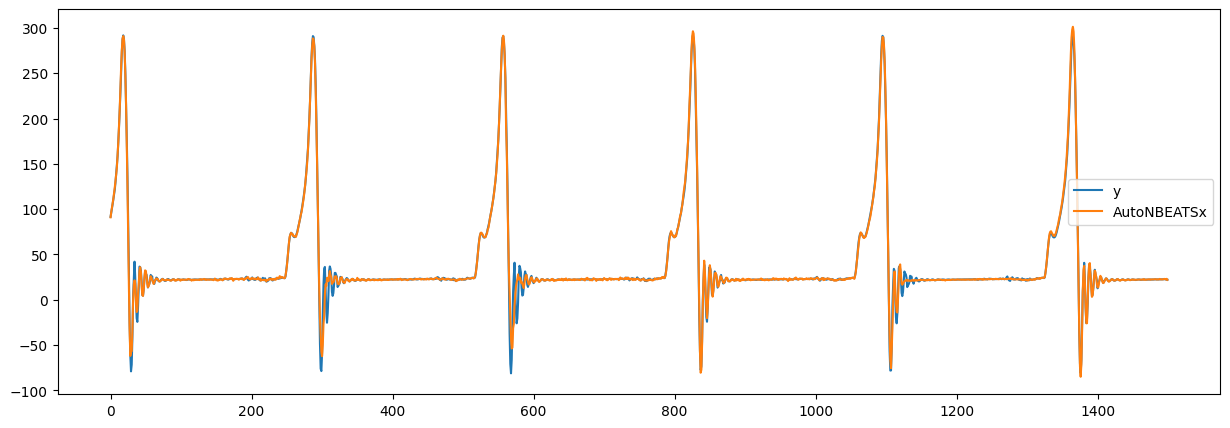

In [30]:
original_scale_df[['y', 'AutoNBEATSx']].plot(figsize=(15, 5));

In [32]:
y_true = original_scale_df['y']
y_pred = original_scale_df['AutoNBEATSx']

In [33]:
print(f"RMSE: {math.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

RMSE: 5.49597865187742
MAE: 1.831049397492483
